# Análisis de cambio semánticos

In [1]:
# Importar librería
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pickle
import os
import re
import random as rn
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import itertools

from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
tqdm.pandas()

from ast import literal_eval

In [2]:
# Configurar
load_dotenv() # Cargar las variables de entorno del archivo .env
BASE_DIR =  os.getenv("DIR_BASE")
RESULTADOS_DIR = os.getenv("DIR_DATOS_PROCESADOS") # Acceder a las variables de entorno
pd.set_option('display.max_colwidth', None)

Se selecciona para analizar el modelo de procrustes

In [3]:
basename = 'procrustes'
iteracion = 10
tam_vector = 50

In [4]:
# estabilidad_procrustes_iter10_tam50
selected_topics_df = pd.read_csv(
    RESULTADOS_DIR+'archivos_out/estabilidad_'+basename+'_iter'+str(iteracion)+'_tam'+str(tam_vector)+'.csv',
    converters={'par_periodo': literal_eval})

selected_topics_df.head(5)

,iteracion,par_periodo,palabra,similaridad_semantica,cantidad_palabras_comun,top10_vecindad_t1,top10_vecindad_t2
0,3,"(2014, 2019)",accion,0.060316,460,"[('comunitario', 0.8162716031074524), ('familia', 0.6966067552566528), ('valor', 0.6862984895706177), ('mental', 0.6720057725906372), ('judicial', 0.6569758653640747), ('maternidad', 0.6415419578552246), ('enfermo', 0.6299411058425903), ('psicologico', 0.6294134855270386), ('listado', 0.6239563226699829), ('julio', 0.6164337992668152)]","[('celula', 0.8134423494338989), ('organo', 0.7656179070472717), ('epidemiologico', 0.7550835013389587), ('recoleccion', 0.7297802567481995), ('proteina', 0.6986029744148254), ('promover', 0.6904392838478088), ('alergia', 0.6731252670288086), ('aplv', 0.6659174561500549), ('donacion', 0.6445348262786865), ('artriti', 0.6362723708152771)]"
1,7,"(2014, 2019)",accion,0.070791,460,"[('comunitario', 0.7522286772727966), ('mental', 0.6940575838088989), ('valor', 0.6743478775024414), ('enfermo', 0.6571216583251953), ('nacimiento', 0.656200110912323), ('psicologico', 0.647275984287262), ('judicial', 0.6461881399154663), ('doctor', 0.6219366192817688), ('familia', 0.6185814738273621), ('julio', 0.6097172498703003)]","[('celula', 0.8234116435050964), ('organo', 0.7737159729003906), ('epidemiologico', 0.7535558938980103), ('proteina', 0.7374798655509949), ('alergia', 0.7036927342414856), ('aplv', 0.7035736441612244), ('recoleccion', 0.699586033821106), ('promover', 0.6792402863502502), ('artriti', 0.6510705947875977), ('donacion', 0.6435563564300537)]"
2,9,"(2014, 2019)",accion,0.108304,460,"[('comunitario', 0.745622456073761), ('mental', 0.6980348229408264), ('nacimiento', 0.6852410435676575), ('enfermo', 0.6534753441810608), ('valor', 0.6441527605056763), ('judicial', 0.6335281133651733), ('doctor', 0.6197770833969116), ('familia', 0.6081218719482422), ('financiero', 0.5998843312263489), ('julio', 0.5922853946685791)]","[('celula', 0.8183236122131348), ('organo', 0.7904226779937744), ('epidemiologico', 0.7390302419662476), ('promover', 0.7035396695137024), ('proteina', 0.6911436915397644), ('recoleccion', 0.6862260699272156), ('alergia', 0.6611330509185791), ('aplv', 0.6442741751670837), ('tratamiento', 0.6258760690689087), ('artriti', 0.6218459606170654)]"
3,8,"(2014, 2019)",accion,0.115089,460,"[('comunitario', 0.7981038689613342), ('mental', 0.7272688746452332), ('enfermo', 0.7023824453353882), ('nacimiento', 0.6843957304954529), ('julio', 0.6659055352210999), ('judicial', 0.6606989502906799), ('doctor', 0.6506366729736328), ('valor', 0.6499730944633484), ('proceso', 0.6204570531845093), ('jubilado', 0.6126476526260376)]","[('celula', 0.8206323385238647), ('epidemiologico', 0.776046097278595), ('organo', 0.7638553977012634), ('recoleccion', 0.7405415773391724), ('proteina', 0.7036986351013184), ('promover', 0.6941348314285278), ('aplv', 0.6740677356719971), ('alergia', 0.6590623259544373), ('artriti', 0.6433089971542358), ('tratamiento', 0.6317470669746399)]"
4,1,"(2014, 2019)",accion,0.124074,460,"[('comunitario', 0.747111976146698), ('valor', 0.685540497303009), ('nacimiento', 0.6660028100013733), ('judicial', 0.6486185789108276), ('mental', 0.6269494891166687), ('doctor', 0.6206169724464417), ('prestacion', 0.6161518096923828), ('enfermo', 0.5973100066184998), ('familia', 0.5968785881996155), ('financiero', 0.5939286351203918)]","[('celula', 0.824191153049469), ('organo', 0.7349839210510254), ('epidemiologico', 0.7304975986480713), ('recoleccion', 0.7110050916671753), ('promover', 0.6935141682624817), ('tratamiento', 0.6879884600639343), ('proteina', 0.6454061269760132), ('alergia', 0.6303538680076599), ('aplv', 0.6153587698936462), ('donacion', 0.6080474853515625)]"


In [5]:
selected_topics_df.describe() # Estadística

,iteracion,similaridad_semantica,cantidad_palabras_comun
count,10930.000000,10930.000000,10930.000000
mean,4.500000,0.675531,560.191217
std,2.872413,0.150272,85.413512
min,0.000000,0.060316,460.000000
25%,2.000000,0.580038,460.000000
50%,4.500000,0.693709,633.000000
75%,7.000000,0.785752,633.000000
max,9.000000,0.963408,633.000000


In [6]:
n = 150
at_least_in_any_decade = 9
pares_periodo = [ (2009, 2014),(2014, 2019)]
topn_periodo = {}

for par_periodo in pares_periodo:
    df =  selected_topics_df[
        selected_topics_df['par_periodo'] == par_periodo
    ].copy()
    
    
    frecPer1 = pd.read_csv(RESULTADOS_DIR+'/archivos_out/frec_para_datos_limpios_por_desplaz_semantico_anios5_'+str(par_periodo[0])+'.csv')
    frecPer2 = pd.read_csv(RESULTADOS_DIR+'/archivos_out/frec_para_datos_limpios_por_desplaz_semantico_anios5_'+str(par_periodo[1])+'.csv')
    frecPer1.columns = ['palabra', 'frec1', 'porc1']
    frecPer2.columns = ['palabra', 'frec2', 'porc2']
    #print(frecPer2.shape)
    topn_all_df = []

    for iter in range(iteracion):
        #print(iter)
        df_topn = df[(df.iteracion==iter)]
        #controlar frec
        #display(df_topn)
        df_topn = df_topn.merge(frecPer1, how='left', on='palabra')
        df_topn = df_topn.merge(frecPer2, how='left', on='palabra')
        df_topn['max_freq_of_any_decade'] = df_topn[['frec1', 'frec2']].max(axis=1)
        df_topn.drop(['frec1', 'frec2', 'porc1', 'porc2'], axis=1, inplace=True) 
        df_topn = df_topn.loc[df_topn.max_freq_of_any_decade>= at_least_in_any_decade].head(n)
        df_topn = df_topn.sort_values('similaridad_semantica', ascending=True).head(n)
        #display(df_topn)
        topn_all_df.append(df_topn)
    
    topn_periodo[par_periodo] = pd.concat(topn_all_df, ignore_index=True)    


#### Intersección promedio
¿Cuál es la intersección promedio de los top 150 palabras entre las 10 ejecuciones del enfoque Procrustes para cada par de periodos comparados  con intervalos de confianza del 95% calculados mediante el método bootstrap? 


In [7]:
def confidence_intervals(data):
    res = bootstrap((data,), np.mean, confidence_level=0.95)
    return (res.confidence_interval.low, res.confidence_interval.high)

In [8]:
topn_periodo_all = topn_periodo.copy() # copiar

In [9]:
for par_periodo in pares_periodo: 
    display(topn_periodo[par_periodo].shape)
    df = topn_periodo[par_periodo]
    data = df['palabra'].value_counts().reset_index()
    data = data[data['count']>2]
    pal_lista = list(data['palabra'].unique())
    df = df[df['palabra'].isin(pal_lista)]
    df = df[['par_periodo', 'palabra', 'similaridad_semantica']].\
    groupby(['par_periodo', 'palabra']).agg(['mean', confidence_intervals]).reset_index()
    #df.sort_values(by='par_periodo', inplace=True)
    df.columns = [
    '_'.join(filter(None, x))
    for x in df.columns.to_flat_index() 
    ]
    topn_periodo[par_periodo] = df
  


(1500, 8)

(1500, 8)

Top 10 palabras 

De los top 150 palabras con más de 9 veces de ocurrencia en alguno de pareas de períodos comparados.

* si Distancia = 1 - similitud coseno (sc)

Interpretación
* dist ~ 0.0 (sc ~ 1)	 La palabra no cambió su significado
* dist ~ 0.5 (sc ~ 0.5)  Cambio moderado
* dist > 0.7 (sc <= 0.3) Cambio fuerte (usos muy distintos)

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convertir datos en DataFrame para visualización
def plot_heatmap(cambios_df, title, top = 10):
    #words, values = zip(*changed_words[:top])  # Tomamos el top 10
    #df = pd.DataFrame({"Palabra": words, "Cambio Semántico": values})
    df = cambios_df.copy()
    plt.figure(figsize=(8, 5))
    sns.heatmap(df.set_index("palabra").T, cmap="Reds", annot=True, fmt=".2f", linewidths=0.5)
    plt.title(title + " Top "+str(top))
    plt.show()



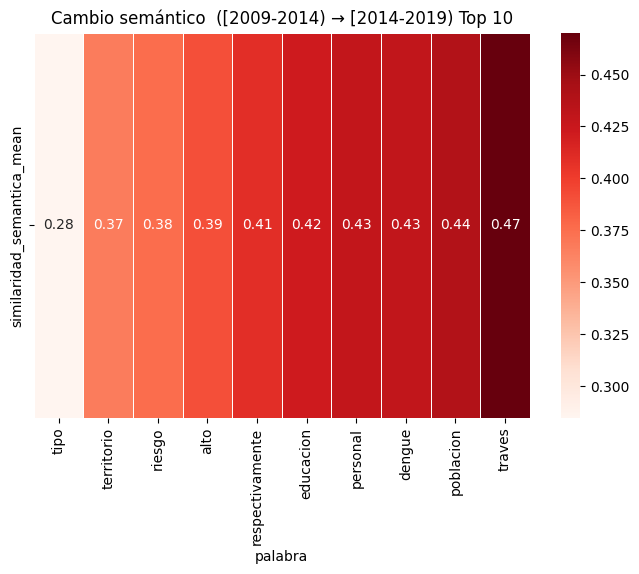

TOP 10 Palabras: ['tipo' 'territorio' 'riesgo' 'alto' 'respectivamente' 'educacion'
 'personal' 'dengue' 'poblacion' 'traves']


,par_periodo,palabra,similaridad_semantica_mean,similaridad_semantica_confidence_intervals
160,"(2009, 2014)",tipo,0.284755,"(0.23477787241265707, 0.32679164560423857)"
159,"(2009, 2014)",territorio,0.366869,"(0.3373731384146464, 0.3943934312183013)"
144,"(2009, 2014)",riesgo,0.375429,"(0.33999934976068963, 0.40953579547008)"
8,"(2009, 2014)",alto,0.390863,"(0.37700490780187174, 0.4026297244695802)"
143,"(2009, 2014)",respectivamente,0.409078,"(0.37139388081293306, 0.4429951820534294)"
54,"(2009, 2014)",educacion,0.422119,"(0.3643457609694012, 0.4629779182670579)"
116,"(2009, 2014)",personal,0.429073,"(0.414380043, 0.4493805907614334)"
44,"(2009, 2014)",dengue,0.430084,"(0.3982220442051593, 0.4561185591567867)"
118,"(2009, 2014)",poblacion,0.438856,"(0.38617822363511595, 0.4756233701489754)"
162,"(2009, 2014)",traves,0.470201,"(0.444982229, 0.502906357)"


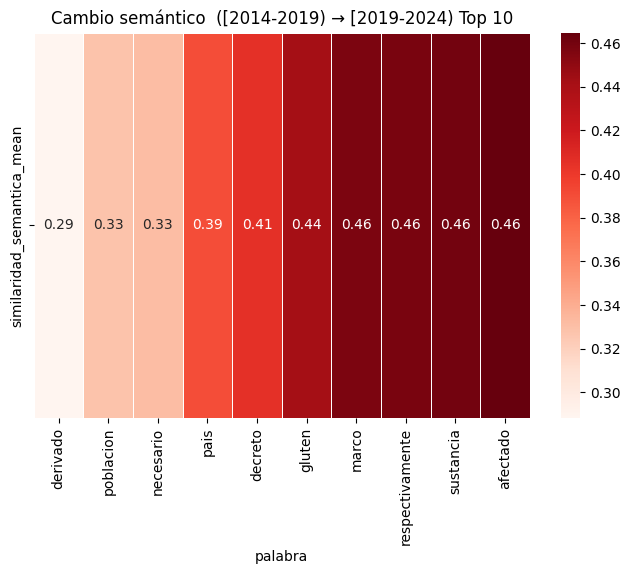

TOP 10 Palabras: ['derivado' 'poblacion' 'necesario' 'pais' 'decreto' 'gluten' 'marco'
 'respectivamente' 'sustancia' 'afectado']


,par_periodo,palabra,similaridad_semantica_mean,similaridad_semantica_confidence_intervals
41,"(2014, 2019)",derivado,0.288478,"(0.24255844640744595, 0.3156624888617759)"
120,"(2014, 2019)",poblacion,0.328418,"(0.2889349489932559, 0.3550804811561772)"
107,"(2014, 2019)",necesario,0.331838,"(0.31127273518545384, 0.3577051229512876)"
115,"(2014, 2019)",pais,0.390323,"(0.3571637987099299, 0.420786354)"
37,"(2014, 2019)",decreto,0.405546,"(0.36797152402502575, 0.4362029874481063)"
71,"(2014, 2019)",gluten,0.442476,"(0.4174846207484643, 0.46307457031502836)"
93,"(2014, 2019)",marco,0.456998,"(0.4294139999079666, 0.48272333155432373)"
143,"(2014, 2019)",respectivamente,0.458549,"(0.4323745430835778, 0.4800211059855102)"
156,"(2014, 2019)",sustancia,0.460149,"(0.42737781031411864, 0.4954156055289141)"
3,"(2014, 2019)",afectado,0.464784,"(0.4356237390002044, 0.4907412790673155)"


In [11]:
topk = 10
for par_periodo in pares_periodo:

    df = topn_periodo[par_periodo].sort_values('similaridad_semantica_mean', ascending=True).head(topk)
    # Graficar Heatmaps
    plot_heatmap(df[['palabra','similaridad_semantica_mean']], "Cambio semántico  (["+str(par_periodo[0])+"-"+str(par_periodo[1])+") → ["+str(par_periodo[1])+"-"+str(par_periodo[1]+5)+")", top=topk)
    print("TOP 10 Palabras:", df['palabra'].unique())
    display(df)    


Palabras comunes entre los pares de períodos

In [12]:
# palabra común en entre períodos
palabra_comun = set(topn_periodo[(2009, 2014)]['palabra'].unique()) & set(topn_periodo[(2014, 2019)]['palabra'].unique())
print("Cantidad de palabras en común:",len(palabra_comun))

Cantidad de palabras en común: 116


Top 10

In [13]:
# Período (2009, 2014)
df = topn_periodo[(2009, 2014)]
df = df[df['palabra'].isin(palabra_comun)]
df = df[['palabra','similaridad_semantica_mean','similaridad_semantica_confidence_intervals']]
df.columns = ['palabra','ss_mean_2009_2014','ss_ci_2009_2014']
# Período (2014, 2019)
df2 = topn_periodo[(2014, 2019)]
df2 = df2[df2['palabra'].isin(palabra_comun)]
df2 = df2[['palabra','similaridad_semantica_mean','similaridad_semantica_confidence_intervals']]
df2.columns = ['palabra','ss_mean_2014_2019','ss_ci_2014_2019']
# Unión
df = df.merge(df2, how='inner', on='palabra')
df = df[['palabra', 'ss_mean_2009_2014', 'ss_mean_2014_2019', 'ss_ci_2009_2014','ss_ci_2014_2019']]
print("Top 10 de palabras comunes con mayor cambio semántco entre Período [2009, 2014) - > [2014, 2019)  ")
print("Palabras:",df.sort_values('ss_mean_2009_2014').head(10)['palabra'].unique() )
display(df.sort_values('ss_mean_2009_2014').head(10))

Top 10 de palabras comunes con mayor cambio semántco entre Período [2009, 2014) - > [2014, 2019)  
Palabras: ['territorio' 'riesgo' 'alto' 'respectivamente' 'personal' 'dengue'
 'poblacion' 'traves' 'educativo' 'complementario']


,palabra,ss_mean_2009_2014,ss_mean_2014_2019,ss_ci_2009_2014,ss_ci_2014_2019
108,territorio,0.366869,0.572571,"(0.3373731384146464, 0.3943934312183013)","(0.5482621800062002, 0.6006869533923592)"
99,riesgo,0.375429,0.621798,"(0.33999934976068963, 0.40953579547008)","(0.6032766787444158, 0.6420865920446205)"
5,alto,0.390863,0.556534,"(0.37700490780187174, 0.4026297244695802)","(0.5359094319994836, 0.5762013538767917)"
98,respectivamente,0.409078,0.458549,"(0.37139388081293306, 0.4429951820534294)","(0.4323745430835778, 0.4800211059855102)"
76,personal,0.429073,0.610532,"(0.414380043, 0.4493805907614334)","(0.579930067601943, 0.6408001056319882)"
28,dengue,0.430084,0.542588,"(0.3982220442051593, 0.4561185591567867)","(0.5178883212531862, 0.557289119671167)"
78,poblacion,0.438856,0.328418,"(0.38617822363511595, 0.4756233701489754)","(0.2889349489932559, 0.3550804811561772)"
110,traves,0.470201,0.496521,"(0.444982229, 0.502906357)","(0.45637699461515696, 0.518656390033757)"
36,educativo,0.476417,0.671805,"(0.45021567987749206, 0.5020491217770829)","(0.6479089209098109, 0.6922738622222222)"
22,complementario,0.494154,0.481353,"(0.4678962367837067, 0.5176475850218802)","(0.44822741252519754, 0.5120967559307625)"


In [14]:
print("Top 10 de palabras comunes con mayor cambio semántco entre Período [2014, 2019) - > [2019, 2024)  ")
print("Palabras:",df.sort_values('ss_mean_2014_2019').head(10)['palabra'].unique() )
display(df.sort_values('ss_mean_2014_2019').head(10))

Top 10 de palabras comunes con mayor cambio semántco entre Período [2014, 2019) - > [2019, 2024)  
Palabras: ['derivado' 'poblacion' 'pais' 'gluten' 'marco' 'respectivamente'
 'afectado' 'hospital' 'universal' 'complementario']


,palabra,ss_mean_2009_2014,ss_mean_2014_2019,ss_ci_2009_2014,ss_ci_2014_2019
31,derivado,0.562405,0.288478,"(0.540823021, 0.5782693218093413)","(0.24255844640744595, 0.3156624888617759)"
78,poblacion,0.438856,0.328418,"(0.38617822363511595, 0.4756233701489754)","(0.2889349489932559, 0.3550804811561772)"
74,pais,0.664162,0.390323,"(0.6460370490456282, 0.6849737309816428)","(0.3571637987099299, 0.420786354)"
47,gluten,0.699813,0.442476,"(0.6828431882707853, 0.7176875962106436)","(0.4174846207484643, 0.46307457031502836)"
59,marco,0.502288,0.456998,"(0.48377156053380294, 0.5222201422900555)","(0.4294139999079666, 0.48272333155432373)"
98,respectivamente,0.409078,0.458549,"(0.37139388081293306, 0.4429951820534294)","(0.4323745430835778, 0.4800211059855102)"
3,afectado,0.729396,0.464784,"(0.72734574, 0.7315837741099911)","(0.4356237390002044, 0.4907412790673155)"
48,hospital,0.693800,0.473493,"(0.68479188625, 0.7077052156863912)","(0.44274679818159063, 0.49100513338767576)"
111,universal,0.646252,0.474290,"(0.6254553889498943, 0.66399547)","(0.44636738337956355, 0.5036952609506723)"
22,complementario,0.494154,0.481353,"(0.4678962367837067, 0.5176475850218802)","(0.44822741252519754, 0.5120967559307625)"


In [15]:
# GUARDAR OBJETO
with open(RESULTADOS_DIR + 'archivos_out/modelos/palComun_cambioSem_procrustes_df.pkl', 'wb') as file: 
    pickle.dump(df,file)

In [16]:
# Palabras en común
df.palabra.unique()

array(['acceso', 'actividad', 'administracion', 'afectado', 'alimento',
       'alto', 'ambito', 'animal', 'anos', 'aplicacion', 'apto',
       'argentino', 'articulo', 'asignacion', 'asistencia', 'atencion',
       'beneficiario', 'cancer', 'caracter', 'celiaca', 'celiaco',
       'centro', 'complementario', 'condicion', 'consumo', 'control',
       'cualquiera', 'cuidado', 'dengue', 'denominado', 'derecho',
       'derivado', 'desarrollo', 'destinado', 'difusion', 'discapacidad',
       'educativo', 'emergencia', 'enfermedad', 'establecer',
       'establecimiento', 'estudio', 'familiar', 'farmacia', 'federal',
       'fondo', 'garantizar', 'gluten', 'hospital', 'humano',
       'implementacion', 'incluir', 'inclusion', 'incorporacion',
       'incorporar', 'infantil', 'institucion', 'integral', 'libre',
       'marco', 'materno', 'medica', 'medicamento', 'menor', 'mental',
       'mes', 'minimo', 'modificacion', 'muerte', 'mujer', 'neonatal',
       'obligatoriedad', 'obligatorio', 

Buscando palabras asociadas a "muerte súbita"

In [17]:
ms_lista = ["emergencia","desfibrilador", "cardiovascular","rcp","subita","muerte"]
for par_periodo in pares_periodo:
    print(par_periodo)
    df = topn_periodo[par_periodo]
    display(df[df['palabra'].str.contains(r"cardio")])

(2009, 2014)


,par_periodo,palabra,similaridad_semantica_mean,similaridad_semantica_confidence_intervals


(2014, 2019)


,par_periodo,palabra,similaridad_semantica_mean,similaridad_semantica_confidence_intervals


### Visualizaciones

t-SNE (t-distributed Stochastic Neighbor Embedding) es un algoritmo de reducción de dimensionalidad que:

Preserva las relaciones locales entre los vectores (es decir, quién está cerca de quién).

No preserva distancias globales ni direcciones.


In [18]:
## 2. Visualización del desplazamiento con t-SNE

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def reducir_dimensionalidad( embeddings, n_components=2, perplexity=5, palabrasComun = []):
    if len(palabrasComun)>0:
        words = palabrasComun
    else:
        words = list(embeddings.keys())
    
    vectors = np.array([embeddings.wv.get_vector(word)  for word in words])
    #embeddings[word]  
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
    
    return reduced_vectors


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Función para reducir dimensiones con t-SNE
def reducir_dimensionalidad(embeddings, n_components=2, perplexity=5):
    words = list(embeddings.keys())
    vectors = np.array([embeddings[word] for word in words])
    
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
    
    return words, reduced_vectors

def reducir_dimensionalidad( embeddings, n_components=2, perplexity=5, palabrasComun = []):
    if len(palabrasComun)>0:
        words = palabrasComun
    else:
        words = list(embeddings.keys())
    
    vectors = np.array([embeddings.wv.get_vector(word)  for word in words])
    #embeddings[word]  
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
    
    return reduced_vectors


# Función para visualizar cambio semántico
def plot_word_shifts(words, m1, m2, vecs1, vecs2, pares, title="Cambio semántico"):
    plt.figure(figsize=(15, 10),tight_layout=True)
    
    for i, word in enumerate(words):
        dist = 1 - compute_cosine_similarity(m1,m2,word)

        plt.scatter(vecs1[i, 0], vecs1[i, 1], color='blue', alpha=0.6)
        plt.scatter(vecs2[i, 0], vecs2[i, 1], color='red', alpha=0.6)
        plt.plot([vecs1[i, 0], vecs2[i, 0]], [vecs1[i, 1], vecs2[i, 1]], color='gray', alpha=0.5)
        plt.text(vecs2[i, 0], vecs2[i, 1], f"{word}\n∆={dist:.2f}", fontsize=9,color='black',ha="left")
        

    
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.title(title,fontsize=20)
    plt.legend([pares[0], pares[1],"Desplazamiento 1−similitud coseno"])
    #plt.tight_layout()
    #plt.subplots_adjust(left=0.2, right=0.5)

    plt.show()

In [20]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

In [21]:
# Crear directorio para algoritmo de cambio semántico
modelo_dir =  RESULTADOS_DIR+ './archivos_out/modelos/estabilidad_procrustes/'
# Crear directorio modelo alineado
alin_dir = modelo_dir +'alineado/'
iter = 0

In [22]:
# modelos alineados por procuster para iter 0
m_2009 = Word2Vec.load(alin_dir+"alin_" + str(2009)+'_'+str(iter)+'.mdl')
m_2014 = Word2Vec.load(alin_dir+"alin_" + str(2014)+'_'+str(iter)+'.mdl') 
m_2019 = Word2Vec.load(alin_dir+"alin_" + str(2019)+'_'+str(iter)+'.mdl')   

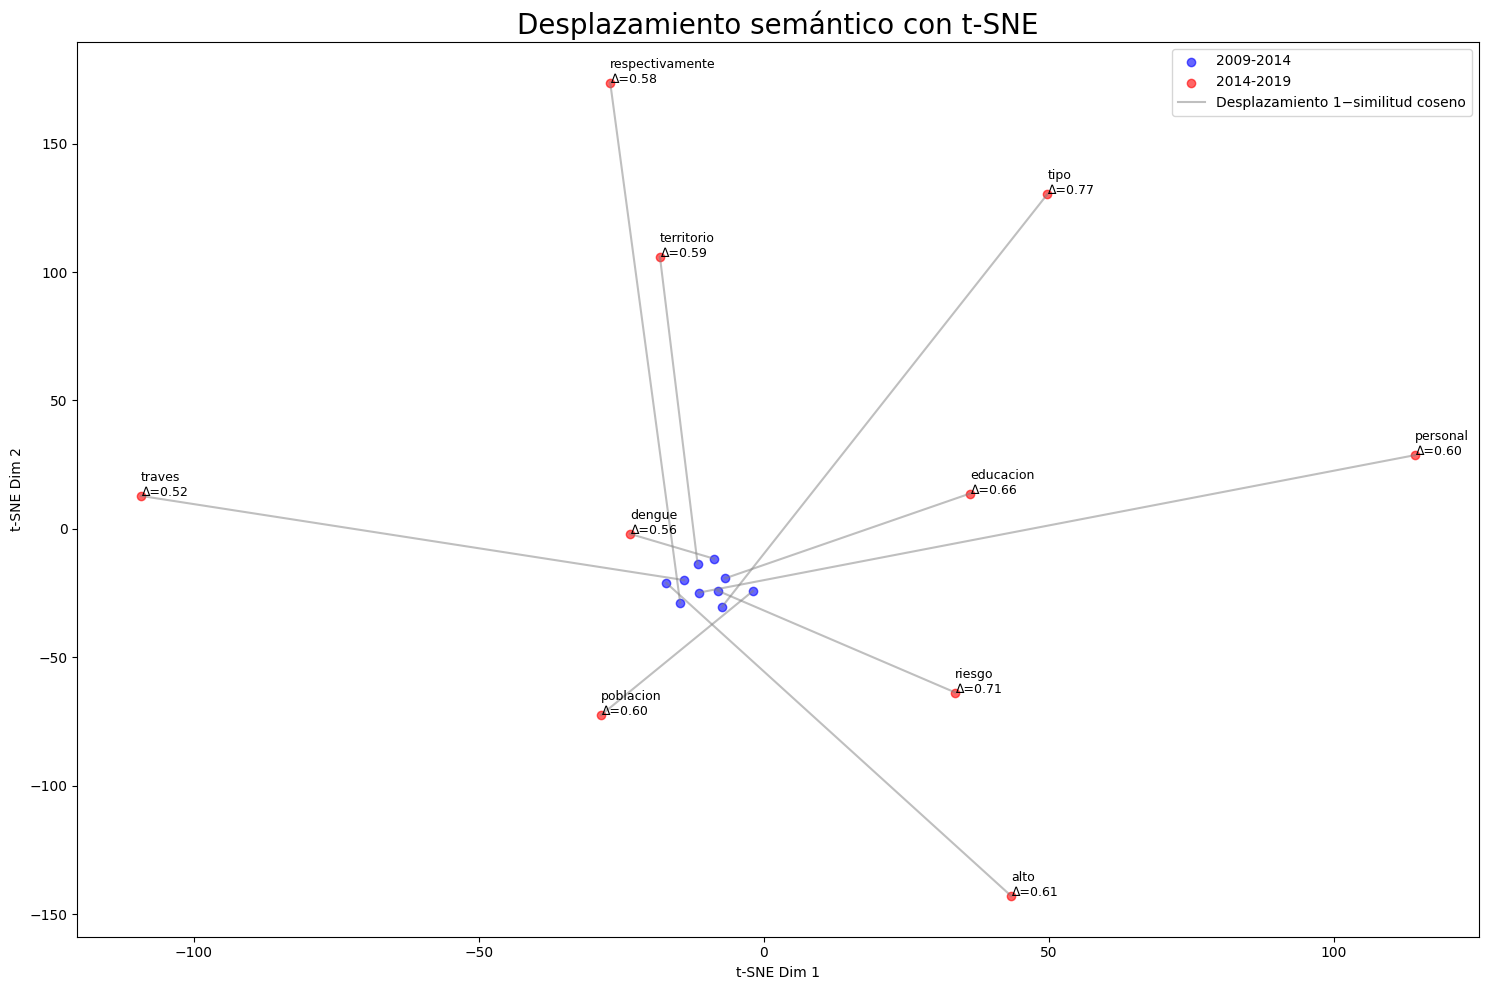

In [23]:
palabrasmc_2009_2014 = ['tipo', 'territorio', 'riesgo', 'alto' ,'respectivamente' ,'educacion',
 'personal' ,'dengue' ,'poblacion' ,'traves']
# Reducir dimensiones para los períodos alineados
vecs_1 = reducir_dimensionalidad(m_2009, palabrasComun = palabrasmc_2009_2014 ) 
vecs_2 = reducir_dimensionalidad(m_2014, palabrasComun = palabrasmc_2009_2014 )
# Graficar cambios semánticos en palabras clave
titulo = "Desplazamiento semántico con t-SNE"
plot_word_shifts(palabrasmc_2009_2014,m_2009,m_2014, vecs_1, vecs_2, ('2009-2014','2014-2019'),titulo)  


No interpretar literalmente las distancias o direcciones en t-SNE (porque puede reordenar todo en 2D).
* Azul: Ubicación de la palabra en el primer período.
* Rojo: Ubicación en el segundo período.
* Línea gris: Movimiento del significado de la palabra.

In [24]:
periodo_df = topn_periodo_all[(2009,2014)]
periodo_df = periodo_df[periodo_df.iteracion==0]
periodo_df = periodo_df[periodo_df['palabra'].isin(palabrasmc_2009_2014)][['palabra','similaridad_semantica','top10_vecindad_t1','top10_vecindad_t2']]
periodo_df['vt1'] = periodo_df['top10_vecindad_t1'].apply(lambda x: [ peso[0] for peso in eval(x) ])
periodo_df['vt2'] = periodo_df['top10_vecindad_t2'].apply(lambda x: [ peso[0] for peso in eval(x) ])
periodo_df[['palabra','similaridad_semantica','vt1','vt2']]

,palabra,similaridad_semantica,vt1,vt2
0,tipo,0.225586,"[causado, aparicion, h1n1, papiloma, virus, gripe, avance, hpv, influenza, cobro]","[ensenanza, deportivo, cualquiera, droga, aptitud, instrumento, tabaquismo, mercurio, organo, importacion]"
1,riesgo,0.291727,"[limitacion, avance, comercializado, cigarrillo, tabaco, argentina, publicitario, cobro, biomedico, numerir]","[exposicion, radiacion, derivado, solar, nacido, recien, reduccion, basico, calorico, modificado]"
2,educacion,0.343539,"[consejo, nutricional, bioetica, enfermeria, superior, republica, trasplante, anatomico, soberania, promover]","[semana, agencia, julio, dengue, septiembre, mes, fiebre, violencia, tumor, transcurso]"
3,alto,0.392504,"[complejidad, traves, glifosato, herbicida, quimico, comision, misoprostol, metodo, investigacion, anmat]","[complejidad, genetico, laboratorio, mision, rotulo, contenido, region, fortalecimiento, identificacion, fondo]"
4,poblacion,0.400131,"[responsable, ambiente, procreacion, trabajo, agregar, ordenamiento, poblacional, fuerza, general, pila]","[comprendido, campana, accesibilidad, reduccion, nocivo, dengue, presupuesto, brindar, permanente, masivo]"
5,personal,0.401885,"[agua, presupuesto, gasificado, elaboracion, lugar, asesor, limitacion, indirecto, deportivo, consumo]","[capacitacion, trabajador, equipo, digital, historia, utilizacion, deportivo, movil, seguridad, basica]"
6,territorio,0.411482,"[aparicion, causado, lavanderia, represa, tintoreria, chaco, ochenta, dengue, percloroetileno, corriente]","[republica, argentina, restaurante, nutricional, comision, alcohol, tecnologico, maquina, natural, porcentaje]"
7,respectivamente,0.423218,"[gasificado, ajuste, semana, potable, agua, gravis, miastenia, bis, acceder, ayuda]","[gasificado, suspension, judicial, donante, autoridad, potable, requisito, valor, adecuado, pension]"
8,dengue,0.436419,"[epidemia, emergente, tropical, chaco, seguimiento, prioritario, sanitario, demencia, aparicion, territorio]","[fiebre, comprendido, prevencion, campana, nocivo, nosocomial, lectivo, transcurso, ciudadano, comite]"
12,traves,0.475491,"[glifosato, herbicida, alto, investigacion, comision, comit, umbilical, masivo, cordon, quimico]","[comite, comit, proceso, dato, adolescente, agente, saludable, apuesta, ambiente, escolar]"


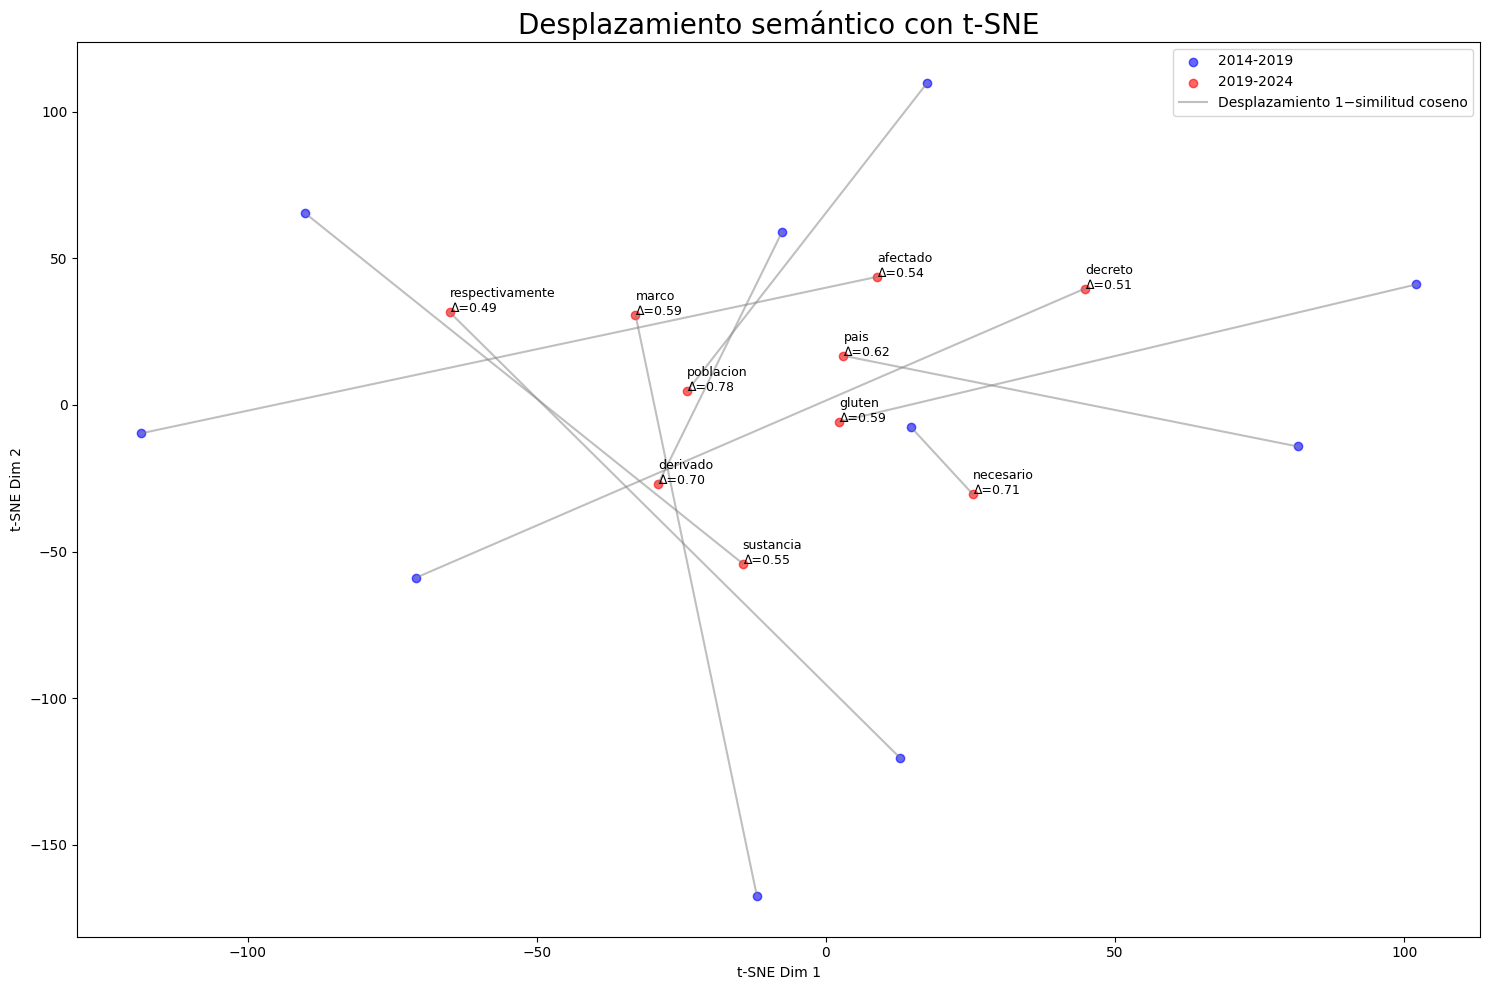

In [25]:
palabrasmc_2014_2019 = ['derivado', 'poblacion', 'necesario', 'pais', 'decreto' ,'gluten' ,'marco',
 'respectivamente', 'sustancia' ,'afectado']
# Reducir dimensiones para los períodos alineados
vecs_1 = reducir_dimensionalidad(m_2014, palabrasComun = palabrasmc_2014_2019 ) 
vecs_2 = reducir_dimensionalidad(m_2019, palabrasComun = palabrasmc_2014_2019 )
titulo = "Desplazamiento semántico con t-SNE"
plot_word_shifts(palabrasmc_2014_2019,m_2014,m_2019, vecs_1, vecs_2, ('2014-2019','2019-2024'),titulo)  


In [26]:
periodo_df = topn_periodo_all[(2014,2019)]
periodo_df = periodo_df[periodo_df.iteracion==0]
periodo_df = periodo_df[periodo_df['palabra'].isin(palabrasmc_2014_2019)][['palabra','similaridad_semantica','top10_vecindad_t1','top10_vecindad_t2']]
periodo_df['vt1'] = periodo_df['top10_vecindad_t1'].apply(lambda x: [ peso[0] for peso in eval(x) ])
periodo_df['vt2'] = periodo_df['top10_vecindad_t2'].apply(lambda x: [ peso[0] for peso in eval(x) ])
periodo_df[['palabra','similaridad_semantica','vt1','vt2']]

,palabra,similaridad_semantica,vt1,vt2
0,poblacion,0.220931,"[comprendido, campana, accesibilidad, reduccion, nocivo, dengue, presupuesto, brindar, permanente, masivo]","[aires, autonoma, prioritario, menor, ciudad, vacunacion, vacuna, autorizar, calendario, familia]"
1,necesario,0.291789,"[subitar, concurrencia, desfibrilador, comida, existir, masivo, radiacion, fetal, automatico, externo]","[misoprostol, precio, principio, produccion, manejo, reproduccion, oporto, garantizar, vino, llamado]"
2,derivado,0.304091,"[exposicion, modificado, geneticamente, riesgo, radiacion, solar, bis, identificacion, masivo, cartel]","[medicinal, planta, droga, comercializacion, distribucion, produccion, autonoma, expendio, aires, ciudad]"
3,pais,0.377555,"[comercialicir, deber, desfibrilador, circuito, externo, cerrado, geriatrico, guarderia, jardin, maternal]","[fabricacion, ejecutivo, exigencia, instalacion, desfibrilador, concurrencia, ciudadano, fiebre, epidemiologico, donacion]"
4,marco,0.411250,"[maternidad, valor, seguro, prepagar, familia, declaracion, medicina, exigencia, judicial, requisito]","[odontologia, cumplimiento, adiccion, profesion, financiero, educacion, fetal, fortalecimiento, semana, periodo]"
5,gluten,0.413047,"[libre, ter, deber, celiaca, comercialicir, restaurante, autoridad, leyenda, menu, exclusivo]","[celiaca, estudio, quimico, prenupcial, sindrome, celiaco, ame, espinal, atrofia, muscular]"
8,sustancia,0.446753,"[ftalato, alergena, leyendo, elemento, empleo, afectar, alimenticio, grasa, odontologico, vino]","[consumo, materia, encontrar, etiquetado, grasa, perjudicial, sodio, alcohol, elaborado, suplemento]"
9,afectado,0.457580,"[ceniza, artriti, neuquen, chubut, negro, biologica, ochenta, medioambiental, volcan, agropecuario]","[abril, mision, chaco, corriente, rio, zona, desastre, santa, provincia, economico]"
18,decreto,0.485572,"[actualizacion, derogacion, hijo, conexa, contributivo, primario, subsistema, movilidad, beneficio, articulo]","[cordoba, norma, organizacion, jubilacion, complementario, modificatoria, santa, farmaceutico, reproduccion, complejidad]"
23,respectivamente,0.510947,"[gasificado, suspension, judicial, donante, autoridad, potable, requisito, valor, adecuado, pension]","[fisico, ter, sangre, publicidad, obligacion, modelo, funcion, licenciado, donante, nutricion]"


#### Vecindades

In [27]:
## 3. Visualización de vecindades semánticas

def plot_neighbors_tsne(word, embeddings_by_period, alineados,periods, top_k=10):
    all_vectors = []
    all_labels = []
    all_colors = []
    center_coords = {}
    legend_labels = []

    color_map = plt.cm.get_cmap("tab10", len(periods))

    for i, period in enumerate(periods):
        if word not in embeddings_by_period[period]:
            print(f" '{word}' no está en el vocabulario del período {period}")
            continue
        
        center_vec = embeddings_by_period[period][word]
        vocab = embeddings_by_period[period]

   

        palabras_masSim = alineados[period].wv.most_similar(positive=[word], topn=top_k)
        neighbors = [ pal_peso[0] for pal_peso in palabras_masSim]
        #palabras_masSim_period1 = m2.wv.most_similar(positive=[palabra], topn=top_k)
        #neighbors = sorted(sims.items(), key=lambda x: x[1], reverse=True)[:top_k]

        # Agregar el centro y sus vecinos
        all_vectors.append(center_vec)
        all_labels.append(word)  # No mostrar periodo en texto
        all_colors.append(i)
        legend_labels.append((period, period+5))

        for neighbor in neighbors:
            all_vectors.append(vocab[neighbor])
            all_labels.append(neighbor)  # Solo mostrar nombre del vecino
            all_colors.append(i)
            legend_labels.append((period, period+5))

    if not all_vectors:
        print("No hay datos suficientes para graficar.")
        return

    X = np.array(all_vectors)
    tsne = TSNE(n_components=2, perplexity=5
                , random_state=42)
    X_2d = tsne.fit_transform(X)

    plt.figure(figsize=(15, 10))
    scatter_handles = {}
    idx = 0
    for i, period in enumerate(periods):
        if (period, period+5) not in legend_labels:
            continue
        color = color_map(i)
        etiqueta = "["+str(period)+","+str(period+5)+")"
        handle = plt.scatter([], [], color=color, label=etiqueta)
        scatter_handles[period] = handle

    max_dist = -1
    max_pair = None

    for i, (x, label) in enumerate(zip(X_2d, all_labels)):
        color = color_map(all_colors[i])
        period = legend_labels[i]
        plt.scatter(x[0], x[1], color=color, s=60)
        if label != word:
            plt.text(x[0], x[1], label, fontsize=9)
        else:
            # es el centro, guardar la coordenada
            plt.text(x[0], x[1], label, fontsize=10, color='blue')

   
    plt.title("Vecindades semánticas (top "+str(top_k)+") para "+word)
   
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(RESULTADOS_DIR+'/archivos_out/estabilidad_procrustes_'+word)

    plt.show()



In [28]:
# Para graficar
embeddings_by_period = {}
alineados = {}
base = 2009
vocab = {}
for modelo in [m_2009,m_2014,m_2019]:
    for word in modelo.wv.key_to_index:
        vocab[word] = modelo.wv.get_vector(word)
    embeddings_by_period[base]=  vocab
    alineados[base] = modelo
    base = base + 5

embeddings_by_period[2009]

{'nacional': array([-0.8117413 , -0.40803716,  0.40184426, -0.09309334,  0.74010336,
        -0.21332076,  0.02630105, -0.08262968, -0.3526857 , -0.07914355,
         0.25100395,  0.02369305,  0.20432697, -0.8469597 ,  0.48670694,
        -0.20174716,  0.32570094, -0.24596375,  0.01674984,  0.11432256,
        -0.9572946 ,  0.4923435 ,  0.10386865, -0.07750045,  0.28072324,
         0.72669405,  0.37892652, -0.3285698 , -0.40088913, -0.06343997,
        -0.00536679,  0.08291034, -0.11768024, -0.04831073, -0.6886244 ,
         0.13970383,  0.35681164, -0.59749866,  0.27672747,  0.05337031,
         0.9071431 , -0.18911795,  0.23925002, -0.16923112,  0.07232238,
         0.67989266, -0.2695147 , -0.1164797 , -0.2837711 , -0.11229423],
       dtype=float32),
 'creacion': array([-0.5553809 , -0.65761226,  0.4752561 ,  0.10894542,  0.42032635,
         0.05998447, -0.28412992, -0.22521935, -0.18712975, -0.10528295,
        -0.19371122,  0.23147286,  0.70361984, -0.1712989 ,  0.31039792,
   

C:\Users\Usuario\AppData\Local\Temp\ipykernel_41916\2119119925.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(periods))


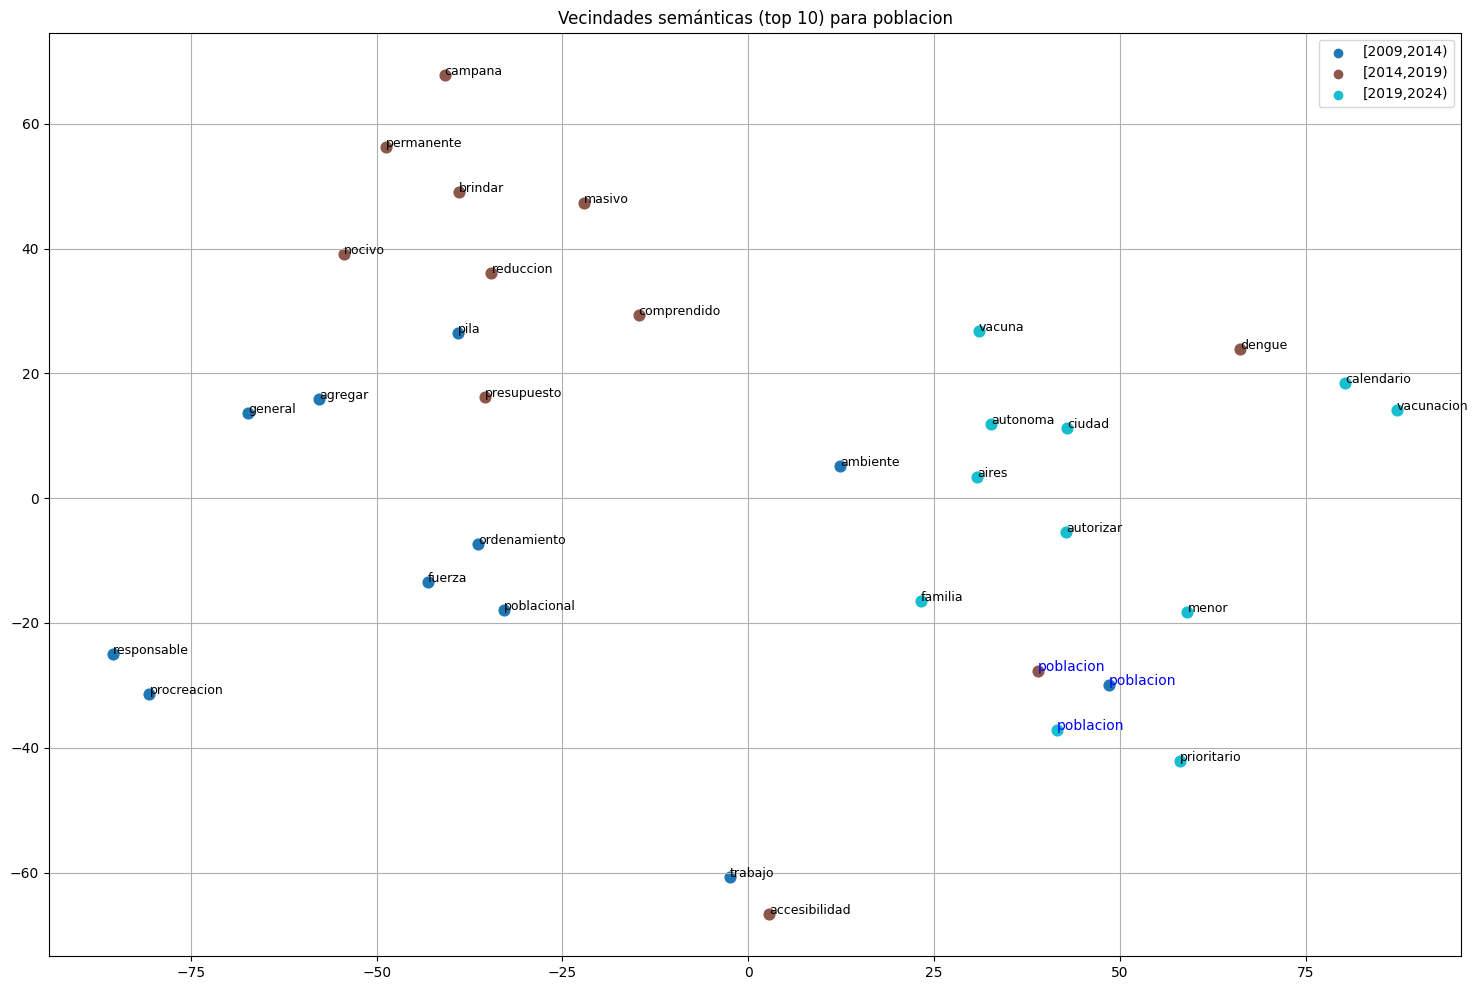

In [29]:

plot_neighbors_tsne('poblacion', embeddings_by_period,alineados, [2009,2014,2019], top_k=10)


Se observa un proceso de cambio semántico en torno a la palabra "población", serán transformaciones discursivas y políticas en salud pública?.

Vamos a analizar los tres períodos y luego sintetizamos el tipo de cambio semántico que está ocurriendo.

🧠 Contextos semánticos de “población” por período
🔹 2009–2013 – Población como categoría estructural o demográfica
Vecinos:
responsable, ambiente, procreación, trabajo, agregar, ordenamiento, poblacional, fuerza, general, pila

👉 Indica una visión estructural-normativa:

Enfoques de planificación poblacional, roles productivos, fuerza laboral.

Términos como “ordenamiento” o “poblacional” sugieren una lógica demográfica y administrativa.

Aparece el vínculo con ambiente, trabajo y procreación, que son ejes típicos de políticas públicas de largo plazo.

🔎 Se perfila un discurso en el que la población es una categoría objeto de organización o gestión estructural.

🔹 2014–2018 – Población como sujeto de intervención social y sanitaria
Vecinos:
comprendido, campaña, accesibilidad, reducción, nocivo, dengue, presupuesto, brindar, permanente, masivo

👉 Aparece una visión operativa, interventiva y comunicacional:

“Población” como grupo destinatario de campañas de salud y políticas de accesibilidad.

Referencias a presupuesto y provisión sostenida de servicios.

Asociaciones con enfermedades concretas (dengue) y conceptos como nocivo, reducción, muestran una preocupación por el riesgo y la prevención.

🔎 Aquí la población es una unidad social sobre la cual se actúa desde la política pública, con foco en prevención y derecho al acceso.

🔹 2019–2023 – Población como grupo priorizado en políticas sanitarias concretas
Vecinos:
aires, autónoma, prioritario, menor, ciudad, vacunación, vacuna, autorizar, calendario, familia

👉 El discurso se vuelve más específico y centrado en intervenciones concretas y urgentes:

Vacunación, calendario, autorizar → vinculan “población” con acciones reguladas y focalizadas del Estado.

prioritario, menor, familia → indican una segmentación y jerarquización de grupos poblacionales.

autónoma, ciudad, aires → introducen una referencia territorial-urbana específica, posiblemente en el marco de políticas diferenciadas por región o pandemia.

🔎 En este período, la población se entiende como un conjunto de grupos específicos (por edad, localización, situación de riesgo) que requieren acciones focalizadas de salud pública, como la vacunación.

📈 ¿Qué tipo de cambio semántico ocurre en “población”?

✅ Cambio semántico gradual desde una concepción estructural y genérica a una operativa, luego segmentada y focalizada.

Período	Sentido dominante de “población”
* 2009–2013	Categoría estructural, demográfica, ligada a planificación estatal.
* 2014–2018	Sujeto de políticas públicas, campañas, prevención y accesibilidad.
* 2019–2023	Grupo priorizado y segmentado en contextos de vacunación y pandemia.

## Muerte súbita

C:\Users\Usuario\AppData\Local\Temp\ipykernel_41916\2119119925.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(periods))


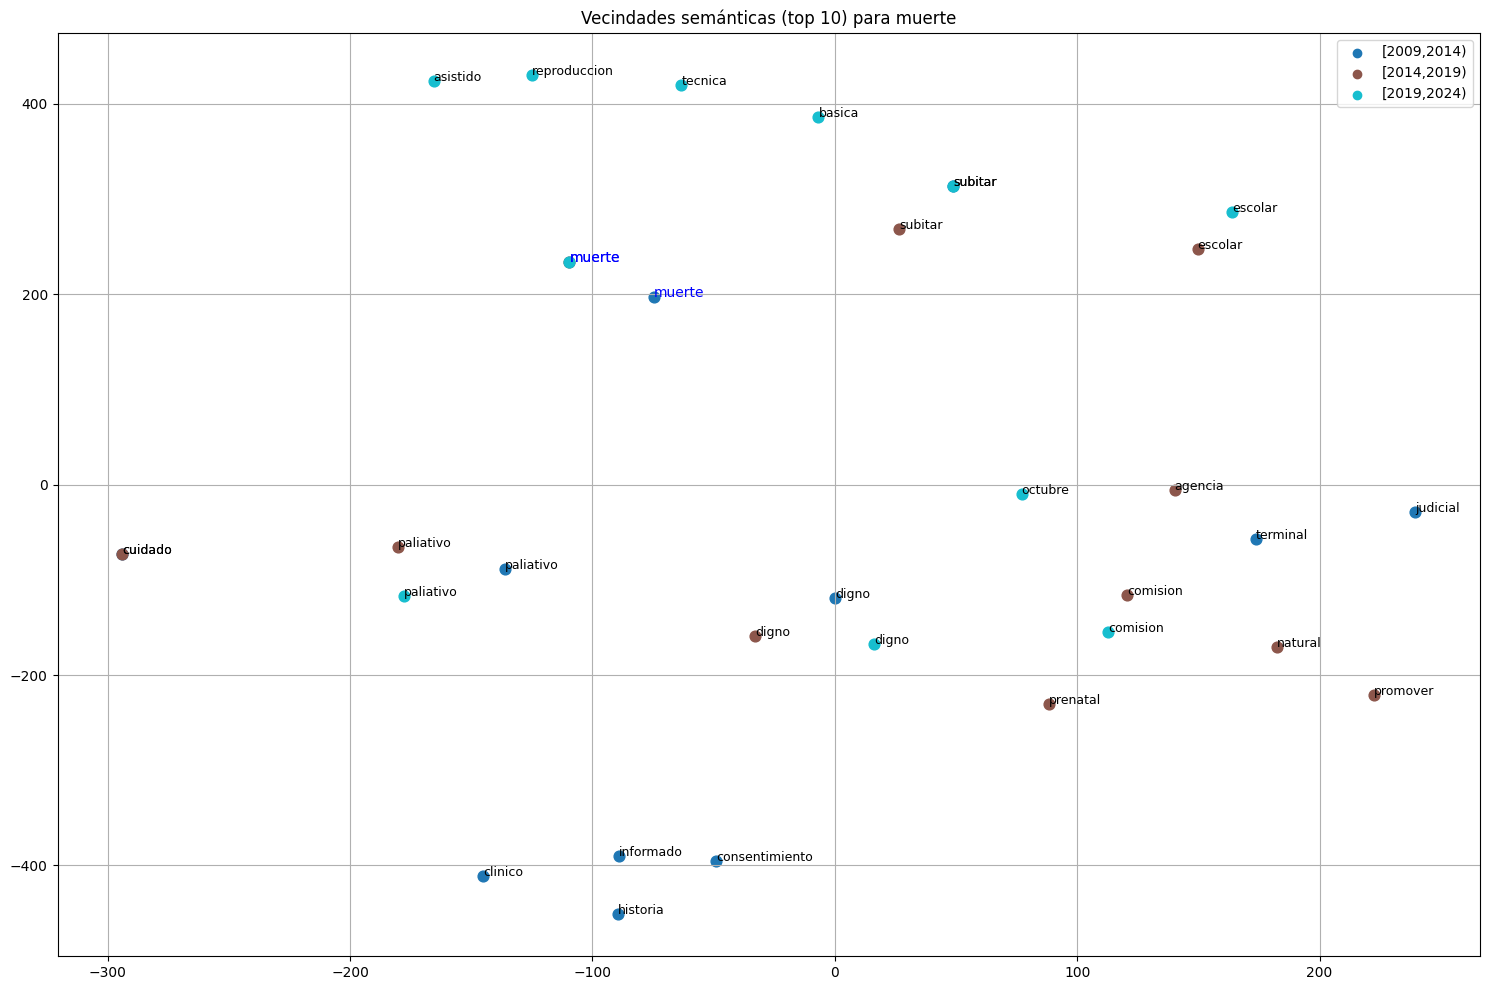

In [30]:
plot_neighbors_tsne('muerte', embeddings_by_period,alineados, [2009,2014,2019], top_k=10)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_41916\2119119925.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(periods))


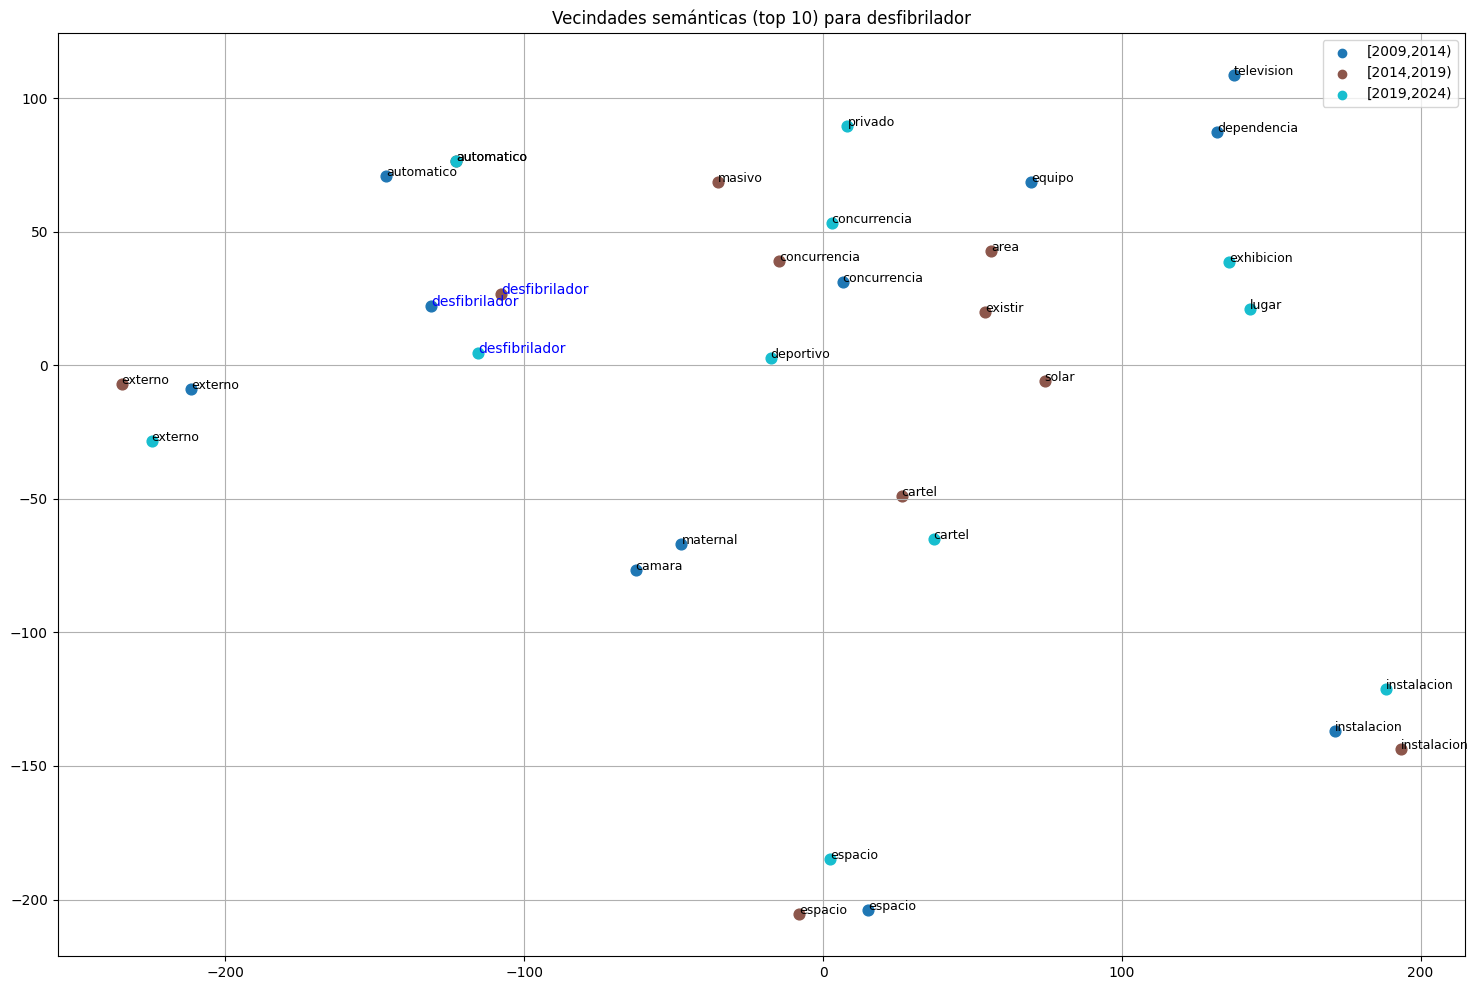

In [31]:
plot_neighbors_tsne('desfibrilador', embeddings_by_period,alineados, [2009,2014,2019], top_k=10)

In [32]:
def_df = selected_topics_df[selected_topics_df.iteracion==0]
def_df = def_df[def_df.palabra=='desfibrilador']
def_df['vt1'] = def_df['top10_vecindad_t1'].apply(lambda x: [ peso[0] for peso in eval(x) ])
def_df['vt2'] = def_df['top10_vecindad_t2'].apply(lambda x: [ peso[0] for peso in eval(x) ])
def_df[['par_periodo','palabra','vt1','vt2']]

,par_periodo,palabra,vt1,vt2
9765,"(2014, 2019)",desfibrilador,"[concurrencia, externo, automatico, area, existir, espacio, masivo, instalacion, solar, cartel]","[automatico, concurrencia, externo, cartel, lugar, privado, instalacion, espacio, exhibicion, deportivo]"
10384,"(2009, 2014)",desfibrilador,"[externo, espacio, automatico, dependencia, instalacion, equipo, concurrencia, maternal, television, camara]","[concurrencia, externo, automatico, area, existir, espacio, masivo, instalacion, solar, cartel]"


🧠 Contextos semánticos de “desfibrilador” por período
🔹 2009–2013 – Enfoque institucional y educativo
Vecinos:
externo, espacio, automático, dependencia, instalación, equipo, concurrencia, maternal, televisión, cámara

👉 Lo que se observa:

Términos como dependencia, maternal, televisión, cámara indican una preocupación por instalar desfibriladores en instituciones públicas o educativas, posiblemente por ley.

Aparecen ideas de presencia en espacios comunes (espacio, concurrencia, instalación) y dispositivos (automático, externo, equipo)

🔎 “Desfibrilador” es presentado como parte de propuestas legislativas para dotar instituciones públicas de herramientas de emergencia. Hay un enfoque institucional y preventivo, especialmente en espacios educativos o de alto tránsito.

🔹 2014–2018 – Enfoque espacial y normativo
Vecinos:
concurrencia, externo, automático, área, existir, espacio, masivo, instalación, solar, cartel

👉 Aparece un discurso más técnico y normativo:

Palabras como área, existir, solar, cartel indican una regulación más detallada de dónde deben estar ubicados los desfibriladores.

Se mantiene la idea de lugares con mucha circulación de personas (masivo, concurrencia, espacio)

🔎 El discurso se vuelve más reglamentarista, apuntando a la presencia obligatoria, señalización y condiciones específicas para la instalación de desfibriladores.

🔹 2019–2023 – Enfoque espacial-sectorial y visible
Vecinos:
automático, concurrencia, externo, cartel, lugar, privado, instalación, espacio, exhibición, deportivo

👉 Se profundiza una lógica de visibilización y expansión al ámbito privado y deportivo:

Aparece el término privado, lo cual indica que la exigencia de instalación ya no se limita al ámbito estatal.

Se suman exhibición, deportivo, lugar, lo que puede sugerir una preocupación por la disponibilidad pública en eventos deportivos o espacios recreativos de alta concurrencia.

cartel sigue marcando la idea de visibilidad y señalización.

🔎 El desfibrilador ya no sólo se instala en instituciones públicas: ahora se exige o promueve en el sector privado, eventos masivos y espacios deportivos, con fuerte énfasis en su ubicación visible y de fácil acceso.

📈 ¿Qué tipo de cambio semántico está ocurriendo?
✅ Cambio semántico de lo institucional a lo normativo, y luego a lo visibilizado y territorializado.

Período	Sentido dominante de “desfibrilador”
2009–2013	Parte de propuestas preventivas en instituciones educativas o públicas.
2014–2018	Objeto técnico regulado por ubicación, señalización y obligatoriedad.
2019–2023	Dispositivo de uso público en espacios de concurrencia, visibilizado y sectorial.

In [33]:
plot_neighbors_tsne('rcp', embeddings_by_period,alineados, [2009,2014,2019], top_k=10)

 'rcp' no está en el vocabulario del período 2009
 'rcp' no está en el vocabulario del período 2014
 'rcp' no está en el vocabulario del período 2019
No hay datos suficientes para graficar.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_41916\2119119925.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(periods))


## Otros

In [34]:
plot_neighbors_tsne('aborto', embeddings_by_period,alineados, [2009,2014,2019], top_k=10)

 'aborto' no está en el vocabulario del período 2009
 'aborto' no está en el vocabulario del período 2014
 'aborto' no está en el vocabulario del período 2019
No hay datos suficientes para graficar.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_41916\2119119925.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(periods))


C:\Users\Usuario\AppData\Local\Temp\ipykernel_41916\2119119925.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(periods))


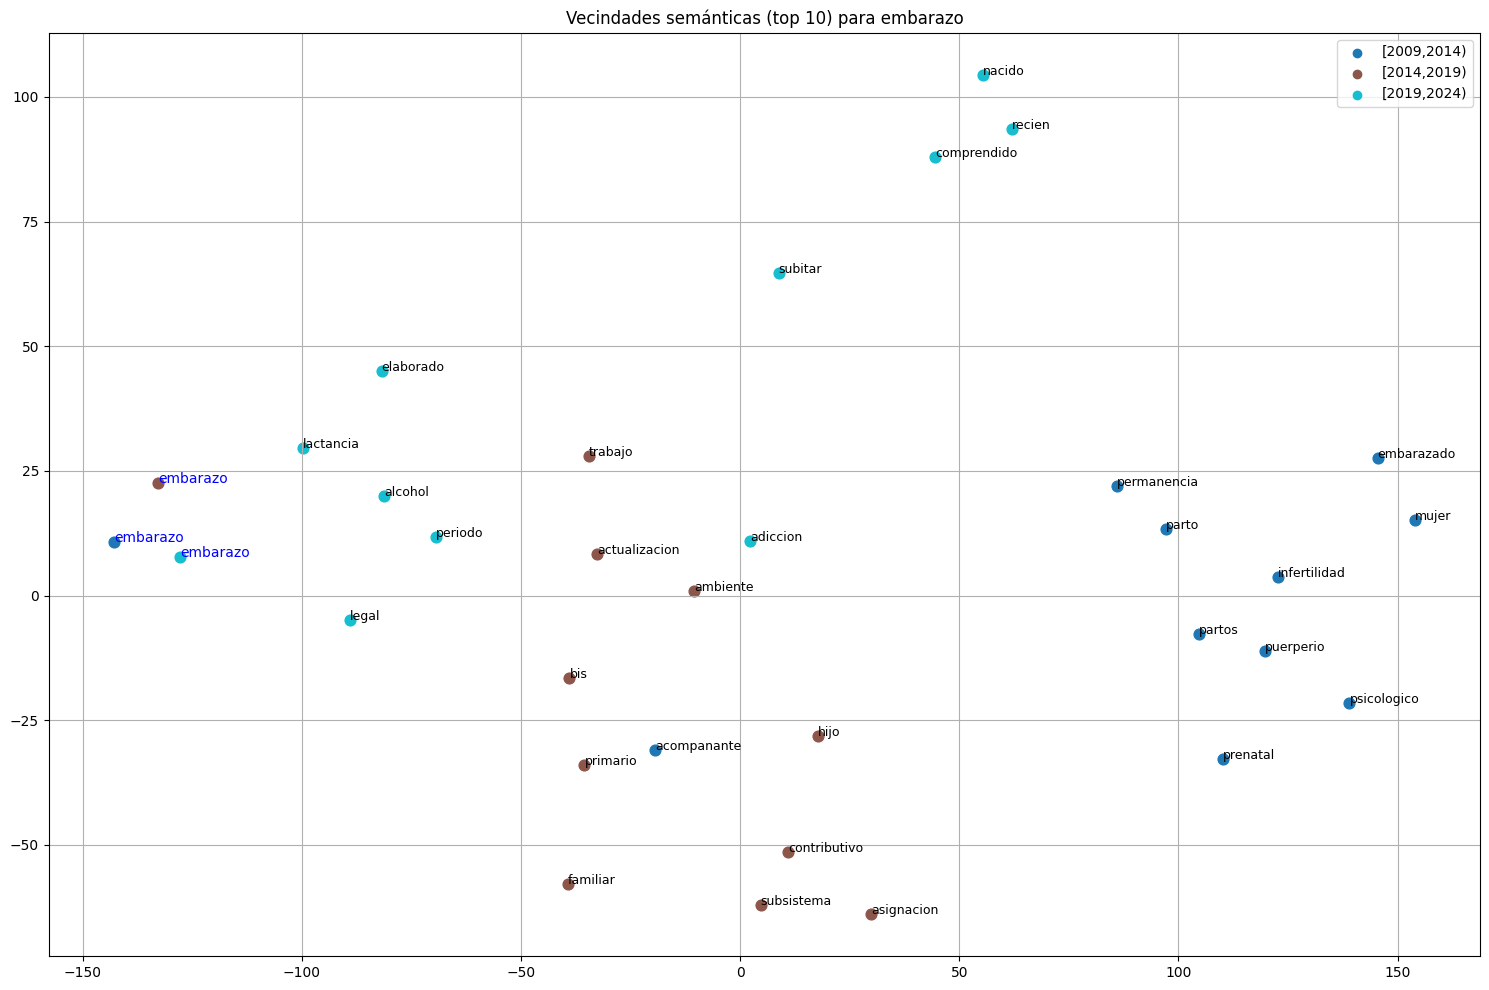

In [35]:
plot_neighbors_tsne('embarazo', embeddings_by_period,alineados, [2009,2014,2019], top_k=10)

### Chat GPT

#### Breve historia del sistema argentino de salud entre 2009 a 2023

Destacando los principales cambios, políticas y desafíos en ese período:

**2009-2015: Ampliación de cobertura y enfoque en salud pública**
* Programa Nacer (iniciado antes) se transformó en Programa SUMAR (2012), ampliando la cobertura sanitaria gratuita a población sin obra social, especialmente niños, embarazadas y adultos hasta 64 años.

* Se fortalecieron las políticas de atención primaria, la distribución gratuita de medicamentos esenciales y el control de enfermedades crónicas.

* Ley Nacional de Salud Mental (2010): marcó un cambio paradigmático hacia una atención centrada en la comunidad, con foco en derechos humanos.

* Inversión en infraestructura y en redes de servicios provinciales, aunque con desigualdades persistentes entre regiones.

**2016-2019: Intento de reformas estructurales y retrocesos por la crisis**

* Lanzamiento de la Cobertura Universal de Salud (CUS) en 2016, con el objetivo de mejorar el acceso de personas sin cobertura formal; sin embargo, tuvo una implementación limitada.

* La crisis económica (inflación, devaluación, recorte del gasto) afectó recursos para salud pública y programas nacionales.

* Tensiones con obras sociales y prepagas por regulaciones, deudas y aranceles.

* En 2018, debate parlamentario por la legalización del aborto generó una movilización social histórica, aunque fue rechazado por el Senado.

**2020-2023: Pandemia, legalización del aborto y digitalización**
* COVID-19 (2020-2021) puso al sistema bajo gran presión: se ampliaron camas, respiradores, se contrató personal y se distribuyeron recursos federales.

* Se desarrolló un plan nacional de vacunación masivo y gratuito, con campañas públicas y centros de vacunación en todo el país.

* En diciembre de 2020 se aprobó la Ley 27.610 de Interrupción Voluntaria del Embarazo, garantizando el derecho a acceder a un aborto legal y seguro hasta la semana 14.

* Se fortaleció la telemedicina y se impulsó la digitalización de historiales clínicos, aunque de manera desigual según la provincia.

* En 2022-2023, el sistema volvió a enfrentar restricciones presupuestarias por la crisis económica, con reclamos de trabajadores de salud, atraso en pagos a proveedores y conflicto con prepagas por aumentos de cuotas y regulación estatal.

#### Conclusión
El sistema de salud argentino entre 2009 y 2023 mostró avances importantes en derechos y cobertura, especialmente con programas públicos y leyes clave (salud mental, aborto). Pero también atravesó crisis económicas y desafíos estructurales que afectaron la calidad y equidad del acceso, manteniéndose como un sistema fragmentado y desigual, con fuerte dependencia de decisiones políticas nacionales y provinciales.

# Anexo

#### Como detectar cambios liguistico con chatgpt

Detectar cambios lingüísticos con ChatGPT u otros modelos de lenguaje puede hacerse de varias formas, dependiendo de qué tipo de cambio te interesa (léxico, semántico, sintáctico, etc.).

* Comparación sincrónica: simular diferentes “épocas” pidiéndole al modelo que hable como si fuera de cierto año:

🗣️ Prompt:
“¿Cómo se usaba la palabra ‘cuidar’ en el contexto de salud pública en Argentina en 2010?”
vs.
“¿Cómo se usa la palabra ‘cuidar’ en el contexto de salud pública en Argentina en 2023?”

* Análisis con embeddings + ChatGPT

Asistente para interpretar cambios de significado basados en embeddings entrenados por año. Ejemplo:
Entrenás vectores (word embeddings) para distintos años. Medís distancia o cambio de contexto de ciertas palabras clave. Usás ChatGPT para ayudarte a interpretar esos cambios

🔍 Prompt:
“En 2010, la palabra ‘prevención’ estaba más cerca de ‘vacuna’, ‘campaña’, ‘dengue’. En 2023, está más cerca de ‘cuidado’, ‘género’, ‘territorio’. ¿Qué tipo de cambio semántico puede estar ocurriendo?”

In [36]:
### PROBANDO CHATGPT

**EDUCACION** 

Entre 2009 a 2013, la palabra ‘educacion’ estaba más cerca de consejo, nutricional, bioetica, enfermeria, superior, republica, trasplante, anatomico, soberania, promover.

Entre 2014 a 2018, está más cerca de semana, agencia, julio, dengue, septiembre, mes, fiebre, violencia, tumor, transcurso.

 ¿Qué tipo de cambio semántico puede estar ocurriendo?

 🧠 Comparación de contextos
🔹 2009-2013 – Educación con sentido institucional y estructural
Vecinos:
consejo, nutricional, bioética, enfermería, superior, república, trasplante, anatómico, soberanía, promover

👉 En este período, la palabra educación está asociada a:

Instituciones educativas (consejo, superior, enfermería)

Formación profesional en salud (bioética, trasplante, anatómico)

Enfoque de soberanía y promoción estatal (soberanía, promover)

🔎 Esto sugiere un uso más estructural, técnico y formal de “educación” dentro del sistema de salud — probablemente en referencia a planes de estudio, formación profesional, políticas institucionales o campañas educativas formales.

🔹 2014-2018 – Educación vinculada a efemérides y campañas
Vecinos:
semana, agencia, julio, dengue, septiembre, mes, fiebre, violencia, tumor, transcurso

👉 Ahora la palabra educación está en un entorno más:

Eventual y temporal (semana, mes, julio, septiembre, transcurso)

Campañas o días de concientización (dengue, fiebre, violencia, tumor)

Agencias organizadoras de eventos (agencia)

🔎 En este período, “educación” parece usarse en el marco de campañas de sensibilización, efemérides sanitarias o eventos de concientización pública, más que en contextos académicos o institucionales.

**POBLACION**

Entre 2009 a 2013, la palabra ‘población’ estaba más cerca de responsable, ambiente, procreacion, trabajo, agregar, ordenamiento, poblacional, fuerza, general, pila

Entre 2014 a 2018, está más cerca de comprendido, campana, accesibilidad, reduccion, nocivo, dengue, presupuesto, brindar, permanente, masivo

 ¿Qué tipo de cambio semántico puede estar ocurriendo?

 🧠 Comparación de contextos para "población"
🔹 2009–2013 – Enfoque estructural, demográfico y normativo
Vecinos:
responsable, ambiente, procreación, trabajo, agregar, ordenamiento, poblacional, fuerza, general, pila

👉 Lo que se ve:

Palabras como “procreación”, “ordenamiento”, “poblacional” indican un enfoque más demográfico y planificador.

Términos como “trabajo”, “ambiente”, “responsable” sugieren vínculos con factores estructurales o sociales.

“Fuerza” y “general” podrían apuntar a enfoques estadísticos o de población en sentido macro.

🔎 Este período sugiere que “población” se enmarca en discursos más normativos, de control o planificación estatal: natalidad, distribución, estructura social y laboral.

🔹 2014–2018 – Enfoque en intervención, acceso y riesgo
Vecinos:
comprendido, campaña, accesibilidad, reducción, nocivo, dengue, presupuesto, brindar, permanente, masivo

👉 Ahora aparecen:

Palabras relacionadas con intervenciones directas o campañas (campaña, reducción, brindar, masivo)

Enfoques de acceso y cobertura (accesibilidad, presupuesto, permanente)

Presencia de problemas de salud pública concretos (nocivo, dengue)

🔎 En este período, “población” está asociada más a la acción sobre la población: intervenciones sanitarias, campañas masivas, servicios de salud, prevención.

📈 ¿Qué cambio semántico sugiere esto?
✅ Desplazamiento discursivo desde:

Educación estructural/profesional en salud (formación, instituciones)

👉 hacia

Educación como herramienta de concientización pública (campañas, efemérides, comunicación)

Este cambio puede reflejar una transformación en la estrategia legislativa de salud pública, donde se empieza a poner más énfasis en la participación ciudadana, la prevención comunitaria y la comunicación de riesgos.

📈 ¿Qué cambio semántico puede estar ocurriendo?
✅ Cambio de un enfoque macro y normativo a uno más operativo y social.

Antes: Población como objeto de planificación estructural y categorización (ordenamiento, fuerza laboral, natalidad, ambiente)

👉 Después: Población como sujeto de intervención y destinataria de políticas de acceso y prevención (campañas, accesibilidad, reducción de riesgos, presupuesto)

🧭 Interpretación más amplia:
Esto podría reflejar un cambio en el discurso legislativo en salud, donde:

Se pasa de una visión más estadística y estructural de la población,

A una visión más intervencionista, orientada al acceso a derechos y servicios, especialmente en el marco de campañas sanitarias o presupuestos públicos.

**TERRITORIO**

Entre 2009 a 2013, la palabra ‘territorio’ estaba más cerca de aparicion, causado, lavanderia, represa, tintoreria, chaco, ochenta, dengue, percloroetileno, corriente

Entre 2014 a 2018, está más cerca de republica, argentina, restaurante, nutricional, comision, alcohol, tecnologico, maquina, natural, porcentaje

 ¿Qué tipo de cambio semántico puede estar ocurriendo?

🧠 Comparación de contextos para “territorio”
🔹 2009–2013 – Enfoque geográfico, ambiental y epidemiológico
Vecinos:
aparición, causado, lavandería, represa, tintorería, chaco, ochenta, dengue, percloroetileno, corriente

👉 Lo que se ve:

Muchas palabras hacen referencia a factores ambientales (represa, percloroetileno, lavandería, tintorería) y a problemas de salud pública locales (dengue, aparición, causado)

También hay una presencia de lugares o regiones (chaco, corriente)

“Ochenta” puede estar vinculado a alguna mención temporal, quizás vinculada a antecedentes históricos o estadísticas.

🔎 Este uso de “territorio” está fuertemente anclado en lo epidemiológico y ambiental: el territorio como espacio físico donde se identifican focos de enfermedad o contaminación. Puede reflejar un enfoque de riesgo ambiental localizado.

🔹 2014–2018 – Enfoque institucional, económico y social
Vecinos:
república, argentina, restaurante, nutricional, comisión, alcohol, tecnológico, máquina, natural, porcentaje

👉 Ahora la palabra “territorio” aparece junto a:

Instituciones y referencias nacionales (república, argentina, comisión)

Consumo, salud y alimentación (restaurante, nutricional, alcohol)

Tecnología y producción (tecnológico, máquina, natural, porcentaje)

🔎 En este período, “territorio” parece adquirir una dimensión más económica, política o institucional. Ya no se trata sólo del lugar donde aparece un problema sanitario, sino del espacio donde se implementan políticas, se regulan actividades productivas o se ejerce soberanía institucional.

📈 ¿Qué tipo de cambio semántico sugiere esto?
✅ Desplazamiento desde un enfoque ambiental-epidemiológico hacia un enfoque institucional-productivo.

Antes:
“Territorio” como espacio físico de riesgo sanitario o contaminación ambiental localizada.

Después:
“Territorio” como espacio político, económico y regulatorio donde se inscriben acciones del Estado, regulaciones alimentarias, actividades tecnológicas o productivas.

🧭 Interpretación discursiva:
Este cambio puede reflejar una ampliación de la idea de territorio:

De un territorio pasivo donde se “detectan” enfermedades,

A un territorio activo donde se implementan políticas, regulaciones o estrategias de producción, nutrición, consumo y tecnología.

Esto puede alinearse con un giro discursivo en salud pública desde una mirada focalizada en brotes hacia una salud territorializada e intersectorial, más integrada con economía, ambiente y alimentación.

**DENGUE**

Entre 2009 a 2013, la palabra ‘dengue’ estaba más cerca de epidemia, emergente, tropical, chaco, seguimiento, prioritario, sanitario, demencia, aparicion, territorio

Entre 2014 a 2018, está más cerca de fiebre, comprendido, prevencion, campana, nocivo, nosocomial, lectivo, transcurso, ciudadano, comite
 
 ¿Qué tipo de cambio semántico puede estar ocurriendo?

🧠 Comparación de contextos para “dengue”
🔹 2009–2013 – Enfoque epidemiológico, territorial y emergente
Vecinos:
epidemia, emergente, tropical, chaco, seguimiento, prioritario, sanitario, demencia, aparición, territorio

👉 Este entorno semántico sugiere que:

El dengue es tratado como una enfermedad emergente (emergente, aparición, prioritario)

Fuertemente vinculado a una problemática geográfica y climática (tropical, chaco, territorio)

También aparece en contextos de vigilancia y seguimiento (epidemia, seguimiento, sanitario)

🔎 Se enmarca dentro de un discurso de alerta epidemiológica, con énfasis en zonas vulnerables y respuestas institucionales de emergencia.

🔹 2014–2018 – Enfoque ciudadano, preventivo y educativo
Vecinos:
fiebre, comprendido, prevención, campaña, nocivo, nosocomial, lectivo, transcurso, ciudadano, comité

👉 En este nuevo período, el dengue:

Se relaciona con campañas y estrategias de prevención y concientización (prevención, campaña, nocivo, ciudadano)

Se inscribe en un discurso más participativo y educativo (comprendido, lectivo, transcurso)

Hay una dimensión más organizativa o institucional de gestión (comité, nosocomial)

🔎 El dengue deja de estar anclado sólo en lo epidémico y pasa a ser parte de campañas sostenidas, actividades educativas y participación ciudadana.

📈 ¿Qué tipo de cambio semántico puede estar ocurriendo?
✅ Desplazamiento discursivo desde una emergencia sanitaria localizada hacia una política sostenida de prevención y participación.

Antes:
El dengue como problema sanitario emergente, vinculado a territorios específicos (norte argentino), con foco en vigilancia epidemiológica y alerta.

Después:
El dengue como enfermedad conocida y prevenible, con énfasis en la acción ciudadana, las campañas de concientización y la gestión institucional sostenida.

🧭 Interpretación discursiva más amplia:
Este cambio semántico puede reflejar:

Una institucionalización del dengue dentro de las políticas sanitarias.

Un giro desde el enfoque biomédico-epidemiológico hacia un enfoque más comunicacional y participativo.

La maduración del abordaje estatal: del control reactivo al trabajo preventivo en comunidad.

* ChatGPT como generador de contextos

Que genere frases típicas del uso de una palabra en distintos años, por ejemplo:

🧠 Prompt:
“Generá 3 frases típicas del uso de la palabra ‘aborto’ en proyectos legislativos de salud en Argentina en 2010 y 3 en 2023.”

También para Validación de hipótesis o Detección de nuevos términos o sentidos